# Снижение размерности пространства

Визуализация данных помогает понять их структуру и, как следствие, подсказывает методы анализа этих данных. Однако отображение многомерных данных на плоскости упирается в слишком большое количество измерений. Следовательно, встает задача отображения большого числа измерений на плоскость.

Ниже генерируются данные состоящие из трех четырехмерных сфер, точки в которых распределены нормально. Если мы построим их четырехмерный эпюр, то границу между этими сферами не будет видно.

In [1]:
from sklearn.datasets import make_blobs

# Интерактивный режим отображения рисунков - масштабирование, перемещение, вращение, ...
#%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
blob_X, y = make_blobs(n_samples=[30, 30, 30], # Хочу три группы по 30 точек.
                       centers=[[-7, -7, -7, -7], # Хочу чтобы центры располагались в этих 4-мерных координатах.
                                [0, 0, 0, 0], 
                                [7, 7, 7, 7]], 
                       cluster_std=2.3, # Хочу дисперсию 2.3
                       random_state=77) # Хочу чтобы каждый раз генерировалась одна и та же картинка.

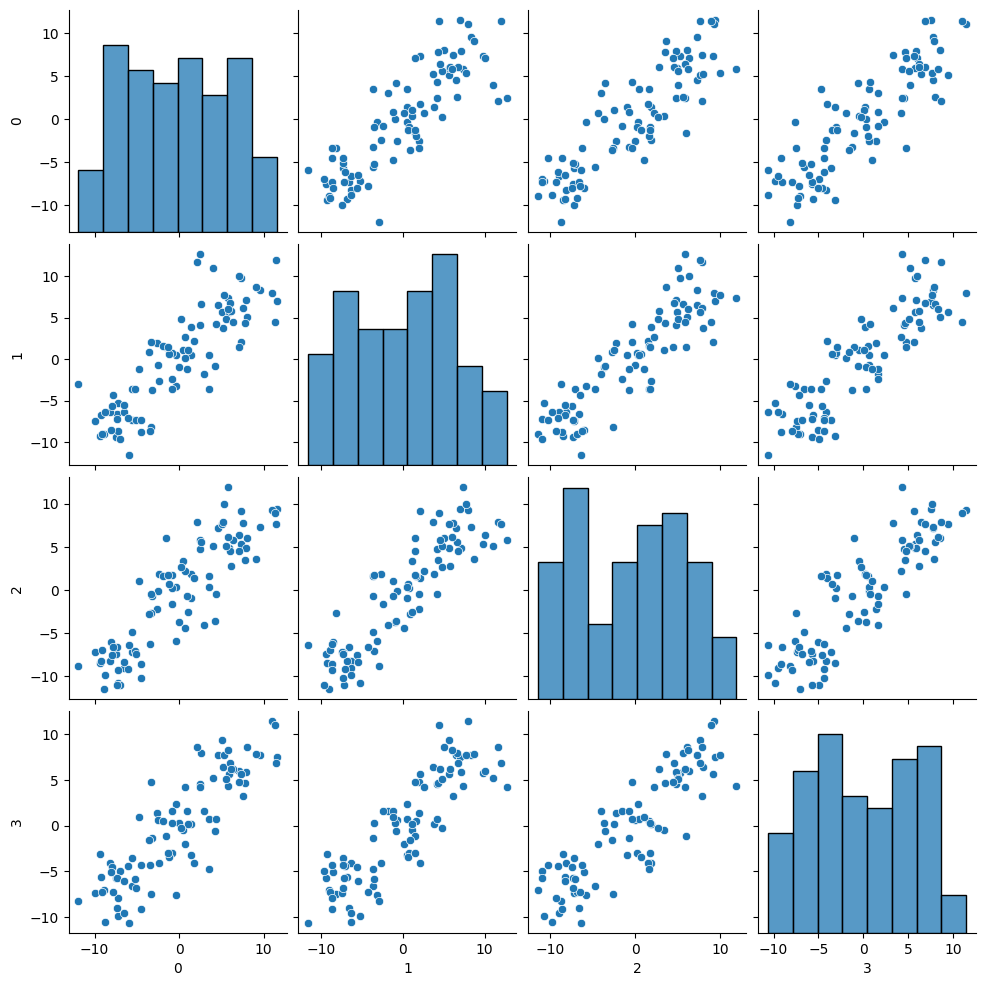

In [3]:
# Построение четырехмерного эпюра для сгенерированных данных.
sns.pairplot(pd.DataFrame(blob_X));

 Однако, если подобрать правильную проекцию для отображаемых данных, то сразу станет видно, что сгенерированные сферы не пересекаются (или почти не пересекаются).

### Метод главных компонент (PCA)

Подберем такую проекцию при помощи <a href="https://habr.com/post/304214/">метода главных компонент</a> (<i>PCA, Principle Component Analysis, <a href="http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html"> документация</a></i>, можно немного потрогать руками <a href="https://setosa.io/ev/principal-component-analysis/">здесь</a>, с большим количеством математики метод описывается на <a href="http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82">machinelearning.ru</a>). Метод основывается на применении сингулярного разложения матриц (SVD). Его суть состоит в том, что мы преобразуем пространство в новое, имеющее меньшую размерность, и строим проекцию на него. Для этого находится новая ось, вдоль которой относительная дисперсия наших данных максимальна. Далее строится проекция всех точек на эту ось, а полученные значения становятся первой координатой в новом пространстве. Это направление отбрасывается, после чего можно снова попытаться найти еще одну ось, еще одну и т.д. Операцию можно повторить столько раз, сколько измерений должно быть в новом пространстве.

![](img/correlated_2d.png)

По умолчанию PCA строит преставление пространства той же размерности, что и входные данные, однако сортирует измерения по "важности".<br>
При помощи функции fit_transform мы настраиваем коэффициенты преобразования (fit) и преобразуем переданные точки (transform). Каждое из этих действий для PCA можно производить по отдельности.<br>

In [4]:
from sklearn.decomposition import PCA

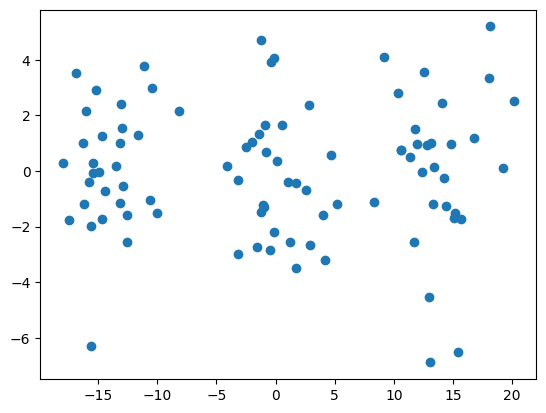

In [5]:
# Создаем объект для преобразования при помощи PCA, 
# он будет преобразовывать в двумерное пространство.
pca_obj = PCA(n_components=2) 
# Настраиваемся на точки, изменяя систему координат, и одновременно
# преобразуем их координаты в два измерения.
show_reduced = pca_obj.fit_transform(blob_X)
# Рисуем точки в преобразованных координатах.
plt.scatter(x=[d[0] for d in show_reduced], 
            y=[d[1] for d in show_reduced]);

Добавим новые точки и сразу преобразуем их в полученное пространство меньшей размерности.

Плюсом метода PCA является тот факт, что после нахождения осей в новое пространство можно преобразовать любую точку исходного пространства. Это возможно, так как преобразование сводится к повороту, масштабированию и проекции.

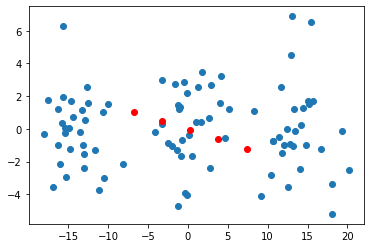

In [6]:
# Генерируем новые точки.
new_points = [(2*i, i, 3*i, i) for i in range(-2, 3)]
# Проецируем их в имеющееся двумерное пространство.
new_2d = pca_obj.transform(new_points)
# Рисуем старые точки.
plt.scatter(x=[d[0] for d in show_reduced], 
                 y=[d[1] for d in show_reduced]);
# Рисуем новые точки.
plt.scatter(x=[d[0] for d in new_2d], 
            y=[d[1] for d in new_2d], 
            c='r');

Можно посмотреть куда "смотрят" новые оси в исходном пространстве.

In [7]:
# Координаты осей в исходном пространстве.
pca_obj.components_

array([[ 0.49230642,  0.50256462,  0.52324478,  0.4809138 ],
       [-0.73737863,  0.66718989,  0.09504508, -0.04579125]])

In [8]:
# Насколько данная координата "объясняет" изменение значений.
pca_obj.explained_variance_ratio_

array([0.90363366, 0.0378258 ])

### Метод t-SNE

Еще одним методом является t-SNE (<i>t-distributed stochastic neighbor embedding</i>). В отличие от предыдущих двух методов, он не строит проекции, а пытается "вдавить" точки в пространство заданной размерности, соблюдая при этом примерное расположение точек. Очевидно, полностью сохранить расположение получается не всегда, но алгоритм старается сделать так, чтобы соседние точки остались соседними.

Примерно такая же картина в смысле разрывов и искажений наблюдается при применении методов наподобие t-SNE. Для разных начальных расположений точек будет получаться разная картина для искажений. Что-то похожее происходит, когда мы рисуем плоскую карту Земли по трехмерному глобусу. При построении такой проекции мы тоже пытаеммся снизить размерность трехмерной фигуры до двух измерений. При этом могут использоваться искажения, то есть мы будем сжимать и растягивать карту. При этом могут возникать разрывы в разных местах. В любом случае, точки, которые были рядом (например, по границе карты) оказываются разнесены друг от друга.

Следует иметь в виду, что в зависимости от того, какую мы выбираем начальную инициализацию, результат может отличаться.

<img src="img/scale_1200.webp" width="400">
<img src="img/675px-Goode_homolosine_projection_SW.jpg" width="400">
<img src="img/728x728_1_c8e398fc8b09167c72d137f7a7fed660@798x798_0xac120003_3215217821597054271.jpg" width="400">
Больше примеров проекций см. <a href = "https://xkcd.com/977/">здесь</a>.



In [6]:
from sklearn.manifold import TSNE

/tmp/ipykernel_240779/3390648099.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(show_reduced[:, 0], show_reduced[:, 1],


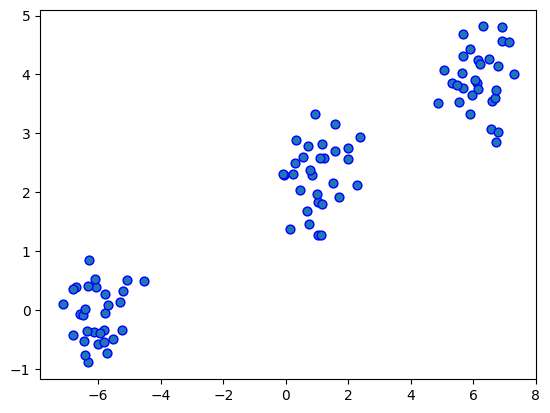

In [7]:
tsne=TSNE()
show_reduced = tsne.fit_transform(blob_X)

fig, ax = plt.subplots()
ax.scatter(show_reduced[:, 0], show_reduced[:, 1], 
           cmap=plt.cm.autumn, edgecolor='b', s=40)
plt.show()


Простое и понятное объяснение, а также визуализацию результатов можно найти [здесь](https://distill.pub/2016/misread-tsne/).

На самом деле, t-SNE случайным образом разбрасывает точки по пространству нужной размерности, а потом проводит оптимизацию функционала взаимодействия между точками. ([Видео с объяснениями](https://www.youtube.com/watch?v=NEaUSP4YerM))

Визуализация работы t-SNE [здесь](https://pair-code.github.io/understanding-umap/).

In [1]:
# Этот код предназначен для того, чтобы посмотреть как движутся точки.
# Этот код не предназначен для того, чтобы в нем копаться с целью понять, как работать с t-SNE!!!

from aux_code.model_springs import *
from ipywidgets import Button, interact, interactive_output, HBox, VBox, Layout, \
                       Output, FloatSlider, IntSlider, Checkbox, Select
from IPython.display import display

import numpy as np

In [2]:
# Глобальные переменные: номер шага, матрица расстояний в исходном пространстве, 
# позиции точек в двумерном пространстве, количество точек.
step_no = 1
dist_matrix = None
positions = None
point_count = 50



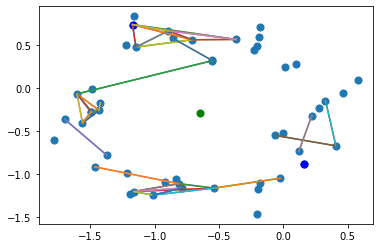

In [6]:
out = Output(layout=Layout(height='400px', width = '600px', border='solid'))
ax = plt.gca()

buttonGen = Button(description='Generate')
buttonStep = Button(description='Step')
vbox = VBox(children=(buttonGen, buttonStep,))
hbox = HBox(children=(out, vbox))
display(hbox)
with out:
    out.clear_output(wait=True)

buttonGen.on_click(generate)
buttonStep.on_click(moveAndDrawPoints2)

init_globals(dist_matrix, positions, point_count, step_no, ax, out)
generate(None)
for i in range(100):
    moveAndDrawPoints2(1)


### Алгоритм UMAP

Это самый свежий алгоритм, он появился в 2018 году - UMAP (<i>Uniform Manifold Approximation and Projection</i>). Принцип работы аналогичен t-SNE. Посмотрим и на его результаты.

Визуализация работы и объяснение практических моментов [здесь](https://pair-code.github.io/understanding-umap/).

<b>Внимание!!!</b>

Для установки используйте umap-learn (https://pypi.org/project/umap-learn/)<br>
Его интерфейс отличается от библиотеки umap.

`pip install umap-learn`

А еще текущая версия библиотеки требует более старой версии numpy, так что надо переставить библиотеку и всё заработает.

In [11]:
import umap
import numpy as np

/tmp/ipykernel_240779/1145755989.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(show_reduced[:, 0], show_reduced[:, 1],


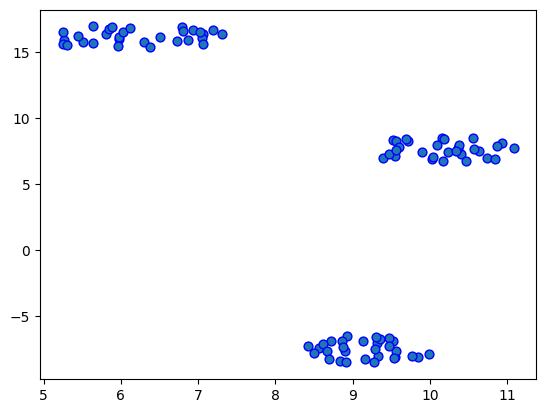

In [9]:
umap_emb = umap.UMAP()
show_reduced = umap_emb.fit_transform(blob_X)

fig, ax = plt.subplots()
ax.scatter(show_reduced[:, 0], show_reduced[:, 1], 
           cmap=plt.cm.autumn, edgecolor='b', s=40)
plt.show()


Теперь посмотрим на классику - ирисы Фишера.

In [14]:
from sklearn.datasets import load_iris

In [15]:
iris = sns.load_dataset('iris')

In [16]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


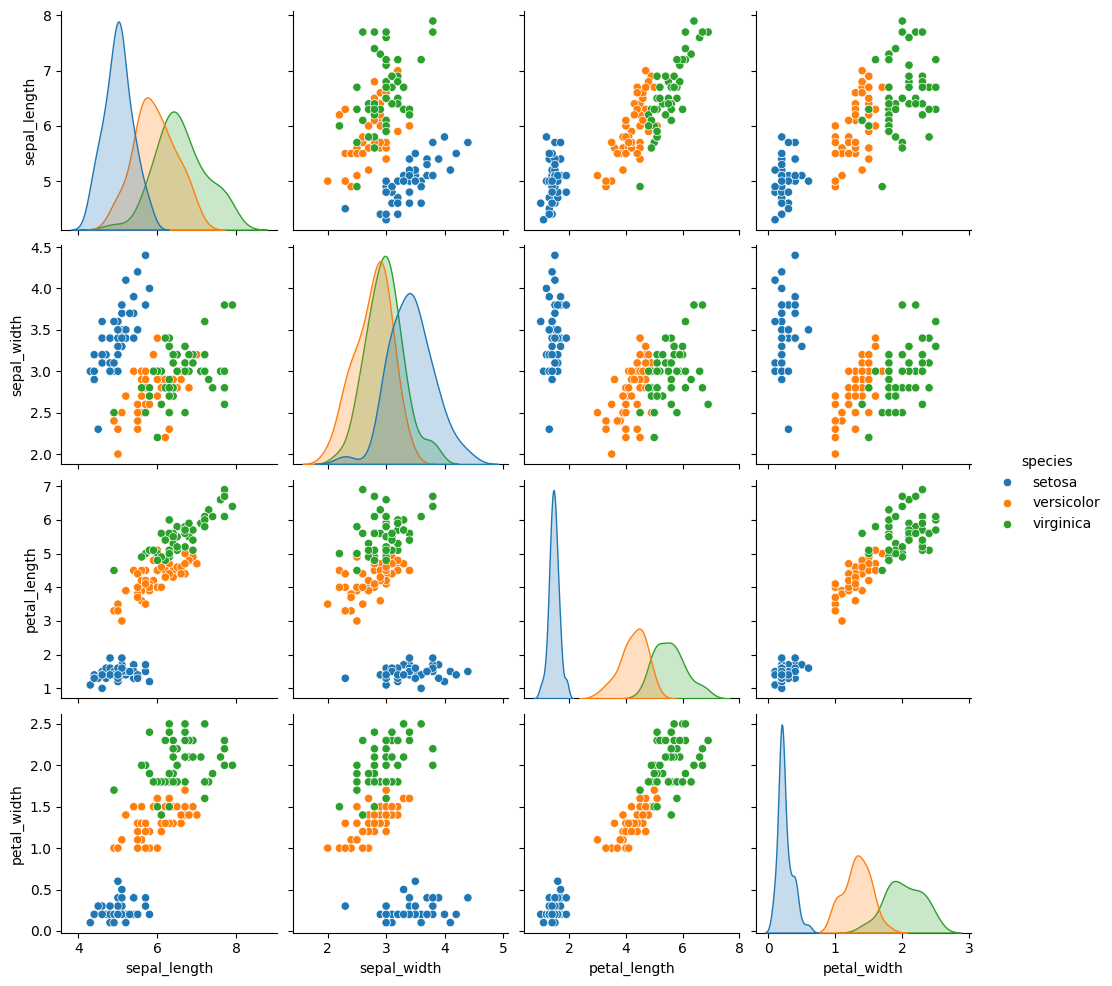

In [17]:
sns.pairplot(iris, hue='species');

Рассмотренные методы обладают следующими достоинствами и недостатками.
- PCA 
    * быстрый (+);
    * повторяющиеся результаты (+);
    * можно добавить новые точки (+);
    * строит проекцию, то есть часть данных теряется (-).
- t-SNE и UMAP 
    * стараются сохранить расстояния между точками (+);
    * это достигается за счет нелинейных искажений (+-);
    * медленнее PCA (-);
    * а текущий момент добавление новых точек возможно только для реализаций UMAP.
    

## Немного чудес со снижением размерности пространства признаков

Посмотрим насколько применение UMAP может улучшить классификацию. 

Возьмем набор данных с рукописными цифрами. Каждая цифра представляет собой картинку 8х8 пикселей, то есть вектор из 64 элементов. 

In [19]:
# Загружаем набор данных.
from sklearn.datasets import load_digits

digits = load_digits()

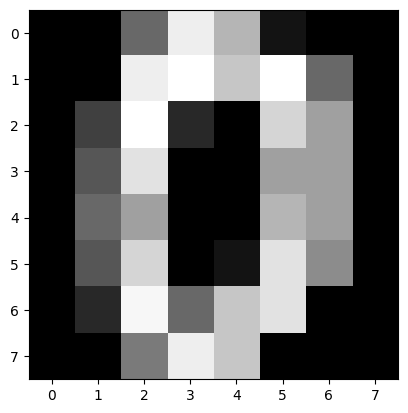

In [20]:
# Посмотрим на одну картинку.
img = digits.images
plt.imshow(img[0], cmap=plt.cm.Greys_r);

In [21]:
# Размер изображения. Само изображение хранится как массив numpy.
img[0].shape

(8, 8)

In [22]:
# Правращаем картинки в вектора.
X = img.reshape(-1, 64)

In [23]:
X.shape

(1797, 64)

In [24]:
# Отделим целевую переменную.
y = digits.target

In [25]:
# Преобразуем координаты при помощи проекции - PCA.
pca2d = PCA(n_components=2)
show_reduced = pca2d.fit_transform(X)


In [26]:
len(show_reduced)

1797

Отобразим полученные проекции. Каждой целевой переменной на графике соответствует свой цвет.

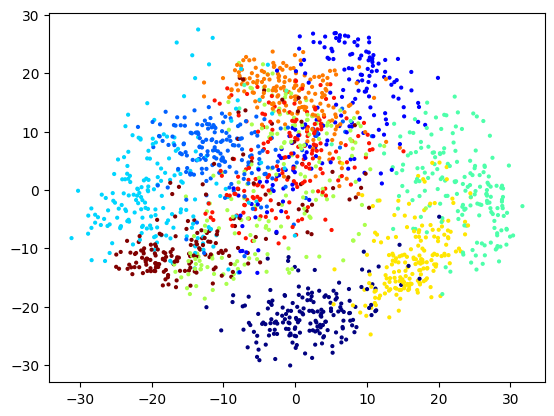

In [27]:
fig, ax = plt.subplots()
ax.scatter([x[0] for x in show_reduced], [x[1] for x in show_reduced], c=y,
           cmap=plt.cm.jet, s=4)
plt.show()

In [28]:
# Сделаем преобразование при помощи UMAP.
umap2d=umap.UMAP(n_components=3)
show_reduced = umap2d.fit_transform(X)


И, о чудо!, цифры разделились!

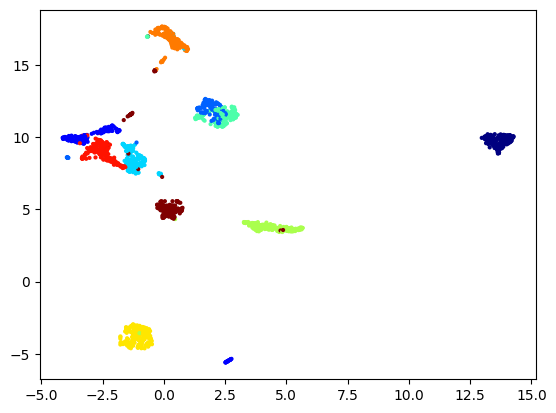

In [29]:
fig, ax = plt.subplots()
ax.scatter([x[0] for x in show_reduced], [x[1] for x in show_reduced], c=y,
           cmap=plt.cm.jet, s=4)
plt.show()

### Некоторые выводы

Рассмотренные методы позволяют проводить следующие действия:
- визуализировать многомерные данные в ходе предварительного анализа, визуализация позволяет прийти к преварительным выводам о возмоности или невозможности применения разных методов анализа;
- снизить размерность анализируемых данных и получить выигрыш в скорости обработки;
- точность анализа после преобразования пространства может как снизиться, так и увеличиться в зависимости от природы данных;
- методы t-SNE и UMAP позволяют работать с предварительно рассчитанными матрицами расстояниями между точками, за счет этого можно преобразовать неметрическое пространство в метрическое.

## Снижение размерности пространства признаков для текстов

Теперь посмотрим каким образом мы можем отобразить векторизованные тексты при помощи новых методов.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as px
import plotly.graph_objects as go


In [31]:
with open("data/lenta2018.txt", encoding="utf-8") as news_file: # Файл с новостями.
    text_news = [n.split("-----\n")[1] for n in news_file.read().split("=====\n")[1:]]
    

In [32]:
cvct = TfidfVectorizer(token_pattern="[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+|[а-яёА-ЯЁ]+-[а-яёА-ЯЁ]+|[а-яёА-ЯЁ]+", 
                       ngram_range=(1, 2))

In [33]:
tfidf_res = cvct.fit_transform(text_news)

In [34]:
umap_text = umap.UMAP(n_components=2)
text_reduced = umap_text.fit_transform(tfidf_res)

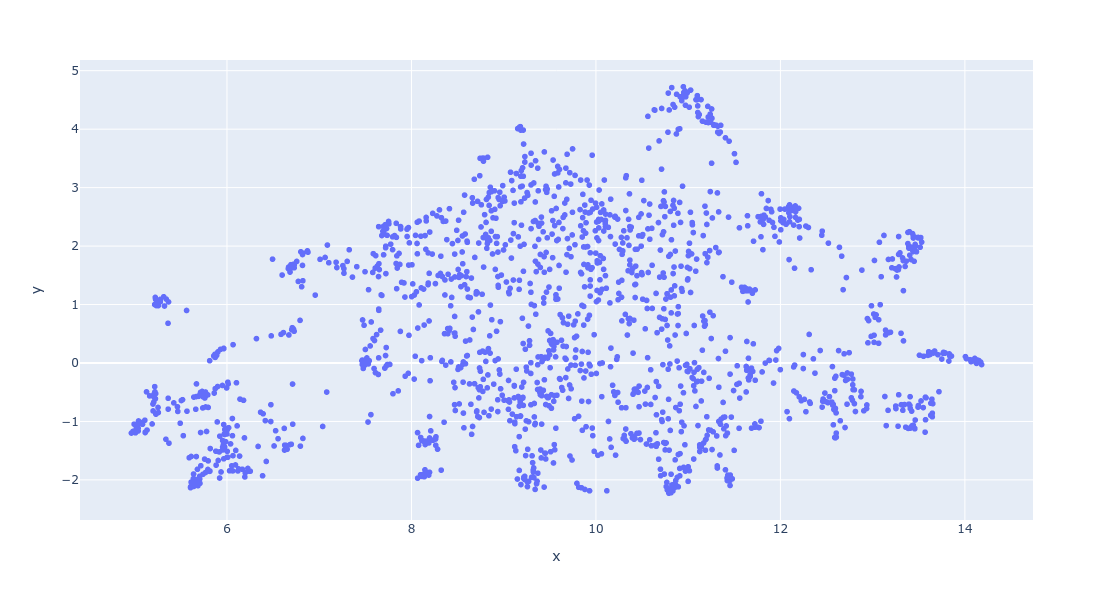

In [35]:
fig= px.scatter(x=text_reduced[:, 0], y=text_reduced[:, 1], height=600, hover_name=[n[:100] for n in text_news])
fig.show()

In [36]:
center = np.array([-5.4, 6.8])
texts_group = [i for i, pt in enumerate(text_reduced) if np.linalg.norm(center-pt)<0.3]

In [37]:
[text_news[i][:100] for i in texts_group]

[]

In [38]:
umap_text3 = umap.UMAP(n_components=3)
text_reduced3 = umap_text3.fit_transform(tfidf_res)

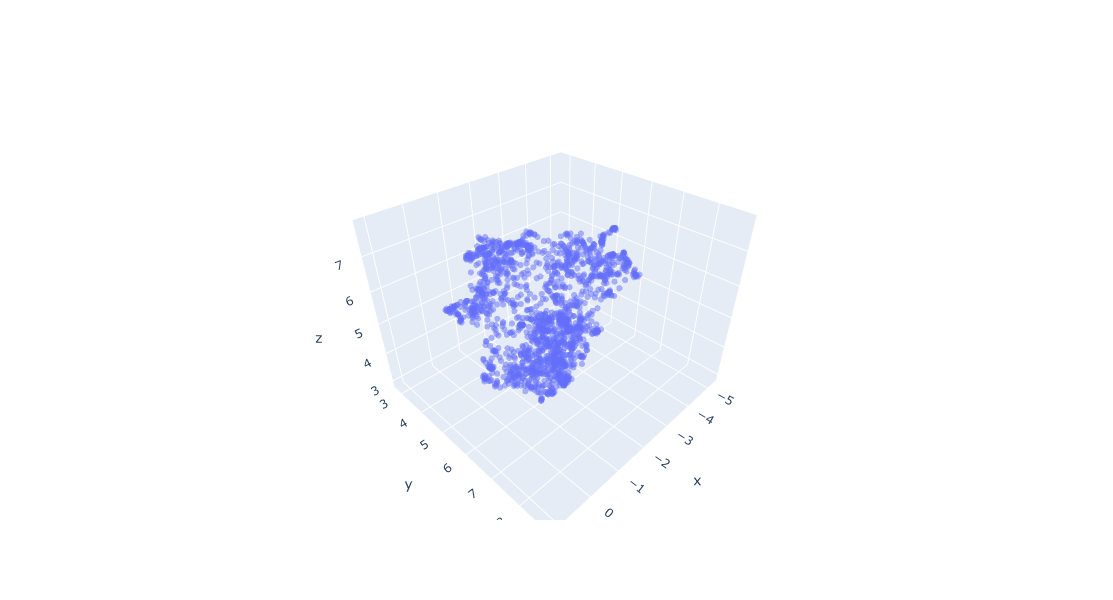

In [39]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=text_reduced3[:, 0], y=text_reduced3[:, 1], z=text_reduced3[:, 2],
    hovertext=[n[:80] for n in text_news],
    mode="markers",
    marker=dict(line=dict(width=0), size=2, 
               ),
    opacity=0.5
))

fig.update_layout(width=800, height=600)
fig.show()


In [40]:
center3 = np.array([-2., 5., 7.])
texts_group3 = [i for i, pt in enumerate(text_reduced3) if np.linalg.norm(center3-pt)<0.5]
[text_news[i][:100] for i in texts_group3]

['Министерство финансов США оправдалось за критику «кремлевского доклада», а именно за то, что список ',
 'Министерство финансов США засекретило часть «кремлевского доклада», чтобы воспрепятствовать выводу а',
 'США не исключают введения в будущем новых санкций против компаний, ведущих бизнес с российским оборо',
 'Растущее присутствие России и Китая в Латинской Америке мешает Вашингтону. Об этом в Техасском униве',
 'Министерство финансов США испугалось вводить санкции против российских государственных облигаций и и',
 'Уполномоченный по правам предпринимателей Борис Титов заявил, что передал президенту России Владимир',
 'Москва не стремится «соблюдать строгую зеркальность» в том, что касается официального ответа на опуб',
 'Кремль готов ознакомиться со списком желающих вернуться из Великобритании в Россию предпринимателей,',
 'Европейские банки ужесточили контроль за счетами российских клиентов. Это связано с подготовкой к пе',
 'Консорциум турецких компаний Cengiz-Kolin-Kalyon (CKK

In [41]:
umap_text3 = umap.UMAP(n_neighbors=15, n_components=3)
text_reduced3 = umap_text3.fit_transform(tfidf_res)

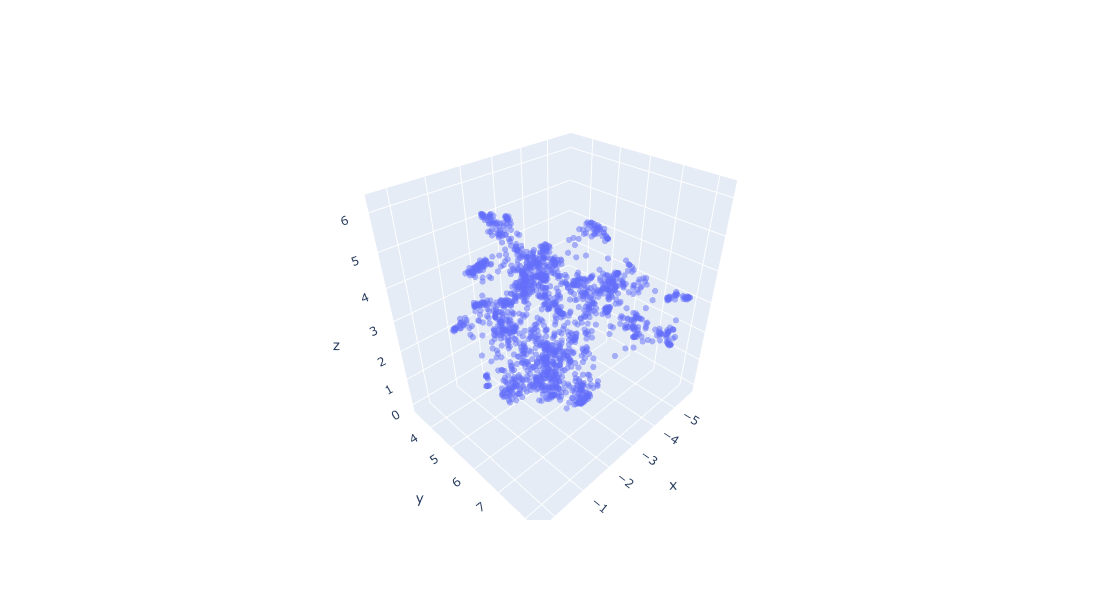

In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=text_reduced3[:, 0], y=text_reduced3[:, 1], z=text_reduced3[:, 2],
    hovertext=[n[:100] for n in text_news],
    mode="markers",
    marker=dict(line=dict(width=0), size=2, 
               ),
    opacity=0.5
))

fig.update_layout(width=800, height=600)
fig.show()


In [43]:
center3 = np.array([-2., 5., 7])
texts_group3 = [i for i, pt in enumerate(text_reduced3) if np.linalg.norm(center3-pt)<1]
[text_news[i][:100] for i in texts_group3]

[]